In [3]:
import numpy as np
import matplotlib.pyplot as plt


class CI:
    def __init__(self, beta_point_est,beta_variance):
        #Remember the beta estimation, dimension and duplication times
        p=beta_point_est.shape[0]
        self.beta_point_est=beta_point_est
        self.beta_variance=beta_variance
        self.p=p
 

    def quantile(self):
        #Calculate the median, 97.5 and 2.5 quantile cut point
        beta_point_est=self.beta_point_est
        beta_variance=self.beta_variance
        p=self.p
        str=" The estimation and 95 percent confidence interval are reported.\n"
        for i in range(p):
            str=str+" The estimation for dimension %d"%(i+1)
            str=str+" is %f."%beta_point_est[i,0]
            beta_i_2_5=beta_point_est[i,0]-1.96*beta_variance[i,0]**(1/2)
            beta_i_97_5=beta_point_est[i,0]+1.96*beta_variance[i,0]**(1/2)
            str=str+" The 95 percent confidence interval is [%f,"%beta_i_2_5
            str=str+" %f].\n"%beta_i_97_5
        return str

In [4]:
##############
##Our method##
##############
#####################################
##Functions for estimate CI for GLM##
#####################################
def generate_glm(n,p,beta):
    #The function to generate GLM data
    #The input beta is matrix
    #The input n,p are scalar
    X=np.random.normal(0,1,[n,p])
    X=np.mat(X)
    Y=np.zeros([n,1])
    for i in range(n):
        eua=np.exp(beta*X[i,:].T)
        prob=eua/(1+eua)
        Y[i]=np.random.binomial(1,prob,1)
    Output=np.zeros([n,p+1])
    Output=np.mat(Output)
    Output[:,-1]=Y
    Output[:,range(p)]=X
    #In output, the first p columns are X and last column is Y
    return Output


def Update_beta_glm(beta_current,X,Y,w,d,iteration,eta,alpha):
    #The function for updating beta_current column by column
    for i in range(d):
        #Calculate the first derivative
        eua=np.exp(X*beta_current[:,i])
        first_d=X.T*(eua/(1+eua)-Y)
        beta_current[:,i]=beta_current[:,i]-w[i]*eta*iteration**(-alpha)*first_d
    return beta_current


def beta_glm(data,p,m,eta,alpha,beta_base):
    #The function to calculate beta estimation variance
    #beta_current is used to save current estimation and beta_sum is used to save beta summation. d is the bootstrap number.
    d=200
    beta_current=np.zeros([p,d])
    beta_current=np.mat(beta_current)
    beta_sum=np.zeros([p,d])
    beta_sum=np.mat(beta_sum)


    #Initial bata_current and beta_sum by zeros
    for time in range(d):
        beta_current[:,time]=beta_base
        beta_sum[:,time]=np.mat(np.zeros([1,p])).T

    iteration=1
    while(iteration<=m):
        X=data[(iteration-1),range(p)]
        Y=data[(iteration-1),-1]
        #w is the weight for bootstrap
        w=np.random.exponential(1,d)
        #Update unknown parameter estimation
        beta_current=Update_beta_glm(beta_current,X,Y,w,d,iteration,eta,alpha)
        #Update beta_sum
        beta_sum=beta_sum+beta_current
        iteration=iteration+1
    return beta_sum/m


#################################################################################################################################################
####################
##Point estimation##
####################
def Update_beta_glm_point(beta_current,X,Y,iteration,eta,alpha):
    #The function for updating beta_current
    #Calculate the first derivative
    eua=np.exp(X*beta_current)
    first_d=X.T*(eua/(1+eua)-Y)
    beta_current=beta_current-eta*iteration**(-alpha)*first_d
    return beta_current


def beta_glm_point(data,p,m,eta,alpha,beta_base):
    #The function to calculate final beta estimation
    #beta_current is used to save current estimation and beta_all is used to save beta estimation process.
    beta_current=np.zeros([p,1])
    beta_current=np.mat(beta_current)
    beta_sum=np.zeros([p,1])
    beta_sum=np.mat(beta_sum)


    #Initial bata_current and beta_sum by zeros
    beta_current=beta_base
    beta_all=np.mat(np.zeros([p,m]))

    iteration=1
    while(iteration<=m):
        X=data[(iteration-1),range(p)]
        Y=data[(iteration-1),-1]
        #Update unknown parameter estimation
        beta_current=Update_beta_glm_point(beta_current,X,Y,iteration,eta,alpha)
        #Remember beta estimation
        beta_all[:,iteration-1]=beta_current
        iteration=iteration+1
    return np.mean(beta_all,1)

In [5]:
##############
##Our method##
##############
#####################################
##Functions for estimate CI for LAD##
#####################################
def generate_lad(n,p,beta):
    #The function to generate linear data
    #The input beta is matrix
    #The input n,p,sigma are scalar
    X=np.random.normal(0,1,[n,p])
    X=np.mat(X)
    Error=np.random.laplace(0,1,n)
    Error=np.mat(Error)
    Y=X*beta.T+Error.T
    Output=np.zeros([n,p+1])
    Output=np.mat(Output)
    Output[:,-1]=Y
    Output[:,range(p)]=X
    #In output, the first p columns are X and last column is Y
    return Output


def Update_beta_lad(beta_current,X,Y,w,d,iteration,eta,alpha):
    #The function for updating beta_current column by column
    for i in range(d):
        first_d=X.T*np.sign(Y-X*beta_current[:,i])*(-1)
        beta_current[:,i]=beta_current[:,i]-w[i]*eta*iteration**(-alpha)*first_d
    return beta_current


def beta_lad(data,p,m,eta,alpha,beta_base):
    #The function to calculate final beta estimation variance
    #beta_current is used to save current estimation and beta_sum is used to save beta summation. d is the bootstrap number.
    d=200
    beta_current=np.zeros([p,d])
    beta_current=np.mat(beta_current)
    beta_sum=np.zeros([p,d])
    beta_sum=np.mat(beta_sum)


    #Initial bata_current and beta_sum by zeros
    for time in range(d):
        beta_current[:,time]=beta_base
        beta_sum[:,time]=np.mat(np.zeros([1,p])).T

    iteration=1
    while(iteration<=m):
        X=data[(iteration-1),range(p)]
        Y=data[(iteration-1),-1]
        #w is the weight for bootstrap
        w=np.random.exponential(1,d)
        #Update unknown parameter estimation
        beta_current=Update_beta_lad(beta_current,X,Y,w,d,iteration,eta,alpha)
        #Update beta_sum
        beta_sum=beta_sum+beta_current
        iteration=iteration+1
    return beta_sum/m 



#################################################################################################################################################
####################
##Point estimation##
####################
def Update_beta_lad_point(beta_current,X,Y,iteration,eta,alpha):
    #The function for updating beta_current 
    first_d=X.T*np.sign(Y-X*beta_current)*(-1)
    beta_current=beta_current-eta*iteration**(-alpha)*first_d
    return beta_current


def beta_lad_point(data,p,m,eta,alpha,beta_base):
    #The function to calculate final beta estimation
    #beta_current is used to save current estimation and beta_all is used to save beta estiamtion process.
    beta_current=np.zeros([p,1])
    beta_current=np.mat(beta_current)
    beta_sum=np.zeros([p,1])
    beta_sum=np.mat(beta_sum)


    #Initial bata_current and beta_sum by zeros
    beta_current=beta_base
    beta_all=np.mat(np.zeros([p,m]))

    iteration=1
    while(iteration<=m):
        X=data[(iteration-1),range(p)]
        Y=data[(iteration-1),-1]
        #Update unknown parameter estimation
        beta_current=Update_beta_lad_point(beta_current,X,Y,iteration,eta,alpha)
        #Remember beta estimation
        beta_all[:,iteration-1]=beta_current
        iteration=iteration+1
    return np.mean(beta_all,1)

In [6]:
##############################################
##Functions for estimate CI for linear model##
##############################################
def generate_linear(n,p,beta,sigma):
    #The function to generate linear data
    #The input beta is matrix
    #The input n,p,sigma are scalar
    X=np.random.normal(0,1,[n,p])
    X=np.mat(X)
    Error=np.random.normal(0,sigma,n)
    Error=np.mat(Error)
    Y=X*beta.T+Error.T
    Output=np.zeros([n,p+1])
    Output=np.mat(Output)
    Output[:,-1]=Y
    Output[:,range(p)]=X
    #In output, the first p columns are X and last column is Y
    return Output


def Update_beta_linear(beta_current,X,Y,w,d,iteration,eta,alpha):
    #The function for updating beta_current column by column
    for i in range(d):
        first_d=X.T*(Y-X*beta_current[:,i])*(-1)
        beta_current[:,i]=beta_current[:,i]-w[i]*eta*iteration**(-alpha)*first_d
    return beta_current


def beta_linear(data,p,m,eta,alpha,beta_base):
    #The function to calculate estimation variance
    #beta_current is used to save current estimation and beta_sum is used to save beta summation. d is the bootstrap number.
    d=200
    beta_current=np.zeros([p,d])
    beta_current=np.mat(beta_current)
    beta_sum=np.zeros([p,d])
    beta_sum=np.mat(beta_sum)

    #Initial bata_current and beta_sum by zeros
    for time in range(d):
        beta_current[:,time]=beta_base
        beta_sum[:,time]=np.mat(np.zeros([1,p])).T

    iteration=1
    while(iteration<=m):
        X=data[(iteration-1),range(p)]
        Y=data[(iteration-1),-1]
        #w is the weight for bootstrap
        w=np.random.exponential(1,d)
        #Update unknown parameter estimation
        beta_current=Update_beta_linear(beta_current,X,Y,w,d,iteration,eta,alpha)
        #Update beta_sum
        beta_sum=beta_sum+beta_current
        iteration=iteration+1
    return beta_sum/m  


######################################
##The function for removing outliers##
######################################
def remove_outlier(x):
    total_count=np.size(x,1)
    y=[]
    ##Calculate median and IQR
    q_50=np.percentile(x,50)
    q_25=np.percentile(x,25)
    q_75=np.percentile(x,75)
    IQR=q_75-q_25
    low=q_25-1.5*IQR
    high=q_75+1.5*IQR
    ##Remove outliers
    for i in range(total_count):
        if x[0,i]>low and x[0,i]<high:
            y.append(x[0,i])
    return y
    
    
#####################################
##Calculate the estimation variance##
##################################### 
def beta_var(beta_estimation):
    p=np.size(beta_estimation,0)
    beta_variance=np.mat(np.zeros([p,1]))
    #Estimate the estimation variance 
    for i in range(p):
        beta_variance[i]=np.var(remove_outlier(beta_estimation[i,:]))
    return beta_variance


#################################################################################################################################################
####################
##Point estimation##
####################
def Update_beta_linear_point(beta_current,X,Y,iteration,eta,alpha):
    #The function for updating beta_current 
    first_d=X.T*(Y-X*beta_current)*(-1)
    beta_current=beta_current-eta*iteration**(-alpha)*first_d
    return beta_current


def beta_linear_point(data,p,m,eta,alpha,beta_base):
    #The function to calculate final beta estimation
    #beta_current is used to save current estimation and beta_all is used to save beta estimation process.
    beta_current=np.zeros([p,1])
    beta_current=np.mat(beta_current)
    beta_sum=np.zeros([p,1])
    beta_sum=np.mat(beta_sum)

    #Initial bata_current and beta_sum by nzeros
    beta_current=beta_base
    beta_all=np.mat(np.zeros([p,m]))

    iteration=1
    while(iteration<=m):
        X=data[(iteration-1),range(p)]
        Y=data[(iteration-1),-1]
        #Update unknown parameter estimation
        beta_current=Update_beta_linear_point(beta_current,X,Y,iteration,eta,alpha)
        #Remember beta estimation
        beta_all[:,iteration-1]=beta_current
        iteration=iteration+1
    return np.mean(beta_all,1)

In [7]:
class beta_hist:
    def __init__(self, beta_estimation):
        #Remember the beta estimation, dimension and duplication times
        p=beta_estimation.shape[0]
        d=beta_estimation.shape[1]
        self.beta_estimation=beta_estimation
        self.p=p
        self.d=d


    def beta_hist_plot(self):
        #Draw the histogram for each dimension
        p=self.p
        d=self.d
        beta_estimation=self.beta_estimation
        hist_list=np.zeros(d)
        for i in range(p):
            #Change the format from matrix to array
            for j in range(d):
                hist_list[j]=beta_estimation[i,j]
            plt.subplot(int(p**(1/2))+1,int(p**(1/2))+1,i+1)
            beta_pic=plt.hist(hist_list,20,range=[np.percentile(hist_list,50)-0.1,np.percentile(hist_list,50)+0.1])
            plt.xlabel("Value")
            plt.ylabel("Frequency")
            plt.title("Histogram for dimension %d"%(i+1))
        return beta_pic

What kind of model would you like? 0 indicates linear model, 1 indicates GLM and 2 indicates LAD.
0
What is dimension of your unknown parameters?
2
What is coefficient of element 1 in unknown parameter?
1
What is coefficient of element 2 in unknown parameter?
-1
What is the standard deviation of basement data error?
0.5
What is total wave number of following data?
2000
What is the tuning parameter eta in stochastic gradient learning?
1
What is the tuning parameter alpha in stochastic gradient learning?
0.66


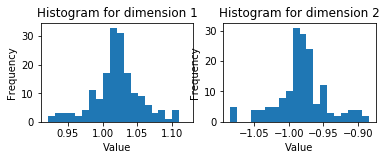

 The estimation and 95 percent confidence interval are reported.
 The estimation for dimension 1 is 1.021415. The 95 percent confidence interval is [0.964942, 1.077887].
 The estimation for dimension 2 is -1.013868. The 95 percent confidence interval is [-1.087525, -0.940211].



In [8]:
def justify_input(integer):
    #Justify if the input is integer
    flag=0
    if integer.isdigit()==False:
        flag=1
    else:
        flag=0
    #If the input is integer, flag=0. Otherwise flag=1
    return flag
    

def justify_model(zero_one_two):
    #Justify if the input is zero or one
    flag=0
    if zero_one_two.isdigit()==False:
        flag=1
    elif int(zero_one_two)<0 or int(zero_one_two)>2:
        flag=1
    else:
        flag=0
    #If the input is zero, one or two, flag=0. Otherwise flag=1
    return flag
        
def main():
    #Denote the linear, GLM or lad model
    model_name=input("What kind of model would you like? 0 indicates linear model, 1 indicates GLM and 2 indicates LAD.\n")
    flag=justify_model(model_name)
    #If the input is not correct, the program will ask the user to input again till correct
    while(flag!=0):
        model_name=input("The last input is not valid. What kind of model would you like? 0 indicates linear model and 1 indicates GLM.\n")
        flag=justify_model(model_name)
    if(int(model_name)==0):
        #The dimension of unknown parameter
        p=input("What is dimension of your unknown parameters?\n")
        flag=justify_input(p)
        #If the input is not correct, the program will ask the user to input again till correct
        while(flag!=0):
            p=input("The last input is not valid. What is dimension of your unknown parameters?\n")
            flag=justify_input(p)
        p=int(p)

        #Let the user input the unknown parameter element by element
        beta=list(range(p))
        for i in range(p):
            beta_i=input("What is coefficient of element %d in unknown parameter?\n"%(i+1))
            beta[i]=float(beta_i)
        beta=np.mat(beta)

        #The error term in linear model
        sigma=input("What is the standard deviation of basement data error?\n")
        sigma=float(sigma)

        m=input("What is total wave number of following data?\n")
        flag=justify_input(m)
        #If the input is not correct, the program will ask the user to input again till correct
        while(flag!=0):
            m=input("The last input is not valid. What is total wave number of following data?\n")
            flag=justify_input(m)
        m=int(m)
    
        eta=input("What is the tuning parameter eta in stochastic gradient learning?\n")
        eta=float(eta)  
        alpha=input("What is the tuning parameter alpha in stochastic gradient learning?\n")
        alpha=float(alpha)   

        #Estimate unknown parameter beta by stochastic gradient learning
        #Give the initial value
        beta_base=np.mat(np.zeros([p,1]))
        #Generate data
        data=generate_linear(m,p,beta,sigma)
        #Calculate point estimation
        beta_point_est=beta_linear_point(data,p,m,eta,alpha,beta_base)
        #Do the bootstrap estimation
        beta_estimation=beta_linear(data,p,m,eta,alpha,beta_base)
        #Estimate the estimation variance
        beta_variance=beta_var(beta_estimation)
    elif(int(model_name)==1):
        #The dimension of unknown parameter
        p=input("What is dimension of your unknown parameters?\n")
        flag=justify_input(p)
        #If the input is not correct, the program will ask the user to input again till correct
        while(flag!=0):
            p=input("The last input is not valid. What is dimension of your unknown parameters?\n")
            flag=justify_input(p)
        p=int(p)

        #Let the user input the unknown parameter element by element
        beta=list(range(p))
        for i in range(p):
            beta_i=input("What is coefficient of element %d in unknown parameter?\n"%(i+1))
            beta[i]=float(beta_i)
        beta=np.mat(beta)

        m=input("What is total wave number of following data?\n")
        flag=justify_input(m)
        #If the input is not correct, the program will ask the user to input again till correct
        while(flag!=0):
            m=input("The last input is not valid. What is total wave number of following data?\n")
            flag=justify_input(m)
        m=int(m)

        eta=input("What is the tuning parameter eta in stochastic gradient learning?\n")
        eta=float(eta)
        alpha=input("What is the tuning parameter alpha in stochastic gradient learning?\n")
        alpha=float(alpha)   
        
        #Give the initial value
        beta_base=np.mat(np.zeros([p,1]))
        #Generate data
        data=generate_glm(m,p,beta)
        #Calculate the point estimation
        beta_point_est=beta_glm_point(data,p,m,eta,alpha,beta_base)
        #Do the bootstrap estimation
        beta_estimation=beta_glm(data,p,m,eta,alpha,beta_base)
        #Estimate the estimation variance
        beta_variance=beta_var(beta_estimation)
    elif(int(model_name)==2):
        #The dimension of unknown parameter
        p=input("What is dimension of your unknown parameters?\n")
        flag=justify_input(p)
        #If the input is not correct, the program will ask the user to input again till correct
        while(flag!=0):
            p=input("The last input is not valid. What is dimension of your unknown parameters?\n")
            flag=justify_input(p)
        p=int(p)

        #Let the user input the unknown parameter element by element
        beta=list(range(p))
        for i in range(p):
            beta_i=input("What is coefficient of element %d in unknown parameter?\n"%(i+1))
            beta[i]=float(beta_i)
        beta=np.mat(beta)

        m=input("What is total wave number of following data?\n")
        flag=justify_input(m)
        #If the input is not correct, the program will ask the user to input again till correct
        while(flag!=0):
            m=input("The last input is not valid. What is total wave number of following data?\n")
            flag=justify_input(m)
        m=int(m)

    
        eta=input("What is the tuning parameter eta in stochastic gradient learning?\n")
        eta=float(eta)
        alpha=input("What is the tuning parameter alpha in stochastic gradient learning?\n")
        alpha=float(alpha)   
        
        #Give the initial value
        beta_base=np.mat(np.zeros([p,1]))
        #Generate data
        data=generate_lad(m,p,beta)
        #Calculate point estimation
        beta_point_est=beta_lad_point(data,p,m,eta,alpha,beta_base)
        #Do the bootstrap estimation
        beta_estimation=beta_lad(data,p,m,eta,alpha,beta_base)
        #Estimate the estimation variance
        beta_variance=beta_var(beta_estimation)    
    
    #Plot the histogram for each dimension
    pic=beta_hist(beta_estimation)
    pic.beta_hist_plot()
    plt.show()
    
    infor=CI(beta_point_est,beta_variance).quantile()
    print(infor)
    

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("Keyboard Interruption")